# Preliminary Techno-Economic Model
Based on Noack et al. (energies paper)

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares

In [2]:
def battery_cost(power_C, energy_C, area_C, facilities_C):
    cost = power_C + energy_C + area_C + facilities_C
    return cost

Constants:

In [3]:
R = 8.3144626 #J/mol-K
F = 96485.33212 #C/mol

In [4]:
things_to_look_up_or_think_about = {}

In [5]:
def Nernst(temp,Concentrations):
    '''
    Takes molar concentrations of the oxidant and reductant at the cathode and anode  
    Returns the standard open circuit voltage of a STACK? 
    '''
    E0_C = 0.401 #V vs SHE for cathode (air electrode)
    E0_A = -.763 #V vs SHE for anode (zinc electrode)
    R = 8.3144626 #J/mol-K
    F = 96485.33212 #C/mol
    T = temp
    z = 2 #electrons?? lol
    C_O2, C_air_OH, C_zinc_zincate, C_zinc_OH = Concentrations
    
    E_C = E0_C + R*T*(z*F)**(-1)* np.log(C_O2**0.5/C_air_OH**2)
    E_A = E0_A + R*T*(z*F)**(-1)* np.log(C_zinc_zincate/C_zinc_OH**4)
    
    #U_rev = (E0_C - E0_A) + R*T*(z*F)**(-1) * np.log(c_C_ox*c_A_red/(c_C_red*c_A_ox))
    U_rev = E_C - E_A
    
    return U_rev

In [6]:
Nernst(298,[1,1,1,1])


1.1640000000000001

In [7]:
def activation_overpotential():
    '''
    the paper said alpha, i_0 and the limiting current density, i_L
    were too difficult to obtain so they were left as constants
    but they supplement the model with measured values later ? 
    '''
    #U_act = alpha*np.log(i/i0)
    
    U_act = 0.005 #V from paper Table 1
    return U_act

In [8]:
def concentration_overpotential():
    '''
    the paper said alpha, i_0 and the limiting current density, i_L
    were too difficult to obtain so they were left as constants
    but they supplement the model with measured values later ? 
    '''
    #U_conc = R*T/(z*F)*np.log(i_L/(i_L - i))
    
    U_conc = 0.02 #V from paper Table 1
    return U_conc

In [9]:
def ohmic_losses(current):
    '''
    Takes in current and returns ohmic losses based on resistances in cell
    '''
    I = current #constant??
    
    b_membrane = .1 #membrane thickness - this is a guess [units?] 
    A_active = 580 #cm^2 [from paper] 
    specific_conductivity_membrane = 1.44 #S/m from paper 
    
    R_membrane = b_membrane/(A_active*specific_conductivity_membrane)
    R_contact = 0 # look up
    R_electrolyte = .0002 #look up
    R_what_else = 0 #think?
    R = R_membrane + R_contact + R_electrolyte + R_what_else
    U_ohm = I*(R)
    
    return U_ohm

In [10]:
def effective_cell_voltage(voltages):
    U_rev, U_act, U_con, U_ohm = voltages
    #U_cell = U_rev + U_act + U_con + U_ohm
    U_cell = U_rev - U_act - U_con - U_ohm
    return U_cell

In [11]:
def power_function(U_cell, N, i, active_area):
    power = U_cell*N*i*active_area
    return power

### Example Framework:

I guess this only works if you set your current

In [12]:
T = 298 #K
example_concs = [1,2,3,4]
Current = 1 #idk 

V_rev = Nernst(T,example_concs)
V_act = activation_overpotential()
V_con = concentration_overpotential()
V_ohm = ohmic_losses(Current)

Vs = V_rev, V_act, V_con, V_ohm
V_cell = effective_cell_voltage(Vs) #calculates the effective cell voltage based on the other voltages.

print ('Effective cell voltage is %.2f V!' %(V_cell))

active_area = 1
ex_current_density = Current/active_area
print ('Power is %.2f mystery units!' %(power_function(V_cell,1,ex_current_density,active_area)))

Effective cell voltage is 1.18 V!
Power is 1.18 mystery units!


In [13]:
ohmic_losses(1)

0.00031973180076628354

# We choose power, it calculates current needed

Right now only ohmic losses ($U_{ohm}$) is a funtion of current. 

P = IV, so if we set a power we also get a set current

In [14]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [15]:
def helppp(test_current):
    T = 293 #K
    # C_O2, C_air_OH, C_zinc_zincate, C_zinc_OH = Concentrations
    example_concs = [0.2095,6,0.2,6]
    V_rev = Nernst(T,example_concs)
    V_act = activation_overpotential()
    V_con = concentration_overpotential()
    Vs = V_rev, V_act, V_con, ohmic_losses(test_current)
    test_P = test_current*effective_cell_voltage(Vs)
    return test_P

#pass 'interact' the function and then the variable name u will change
#=(min,max,step)
interact(helppp,test_current=(-100,100,1))
# interact(helppp,test_current=(-38,-37,.01))

interactive(children=(IntSlider(value=0, description='test_current', min=-100), Output()), _dom_classes=('widg…

<function __main__.helppp(test_current)>

Text(0, 0.5, 'Power')

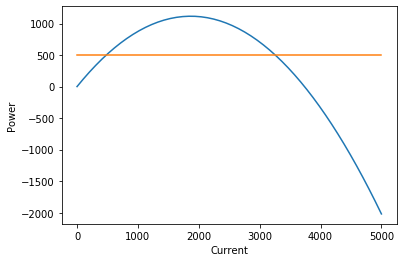

In [16]:
#VIsualize
x = np.linspace(0,5000)
c_of_x = helppp(x)

plt.plot(x,c_of_x)
plt.plot(x,np.ones_like(x)*500)
plt.xlabel('Current')
plt.ylabel( 'Power' )

In [17]:
# Power = 500

def objective_function(guess_current, *power):
    T = 600 #K
    example_concs = [1,2,3,4]
    
    V_rev = Nernst(T,example_concs)
    V_act = activation_overpotential()
    V_con = concentration_overpotential()
    V_ohm = ohmic_losses(guess_current)

    Vs = V_rev, V_act, V_con, V_ohm
    V = effective_cell_voltage(Vs)

    return power - guess_current*V

# current_maybe = least_squares(objective_function, [0,1000],args=([Power]))
# print('Calculated current is %.4f'%(current_maybe.x[0]))
# print(current_maybe.x )
# print('yay it matches above!')

depending on what we want, we could also have a function that minimizes (maximizes? idk is it supposed to be negative?/ confused)ohmic losses based on the possible currents that would work for our desired power. 

In [18]:
def minimize_ohmic_losses(possible_currents):
    '''
    pass me the least_squares solution array from the 
    get_current_from_power function and I will tell you
    which one gives minimum ohmic losses
    '''
    losses = ohmic_losses(possible_currents)
    min_ohmic_loss = np.min(losses)
    index = np.argmin(losses)
    corresponding_current = possible_currents[index]
    return min_ohmic_loss, corresponding_current

answer = minimize_ohmic_losses(current_maybe.x)
print('minimum ohmic loss for your power setting of %d watts (units?) is %.1f volts(?) at a current of %.2f amps(units?)'%(Power, *answer))

NameError: name 'current_maybe' is not defined

Here we need a plot of voltage and current as a function of power damand 

Would power demand be in form of duty cycles? step functions?   ? 

Another plot of operating costs as function of power/voltage/current

In [19]:
Power = 100
guesses = [0,1000] #find some better upper limit than '1000'
current_lists = least_squares(objective_function, guesses ,args=([Power]))

current = min(current_lists.x)
voltage = Power/current

In [20]:
Power_demands = [100,500,1000,700,800,1200,200,450]
times = [1,2,3,4,5,6,7,8]
currents = []
voltages = []

for i in range(len(Power_demands)):
    Power = Power_demands[i]
    possible_currents = least_squares(objective_function, guesses ,args=([Power]))
    current = min(possible_currents.x)
    voltage = Power/current
    currents.append(current)
    voltages.append(voltage)
    
Power_demands, currents, voltages

([100, 500, 1000, 700, 800, 1200, 200, 450],
 [83.94369846552658,
  467.9472498417072,
  1197.0706950358287,
  705.188005469885,
  843.5109592643697,
  1904.8985317298068,
  171.94884864269375,
  414.5261245803382],
 [1.1912746498900963,
  1.068496502905264,
  0.8353725507999924,
  0.9926430888931129,
  0.9484168417890909,
  0.6299548138715294,
  1.1631366047445655,
  1.0855769354840425])

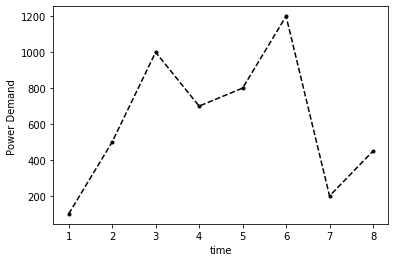

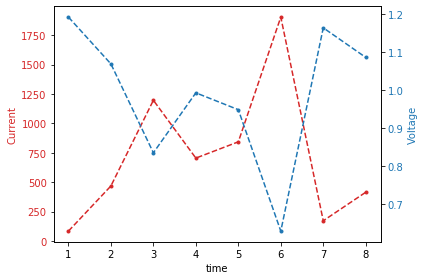

In [21]:
# plt.plot(Power_demands,currents,'b')
# plt.plot(Power_demands,voltages,'r')

plt.plot(times,Power_demands,'.--k')
plt.xlabel('time')
plt.ylabel('Power Demand ')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Current', color=color)
ax1.plot(times,currents, '.--',color=color)
# ax1.plot(times,Power_demands, '*',color='tab:grey',label = 'Power Demand (kW)')
ax1.tick_params(axis='y', labelcolor=color)
# plt.legend(loc = 'upper center')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Voltage', color=color)  # we already handled the x-label with ax1
ax2.plot(times, voltages, '.--',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

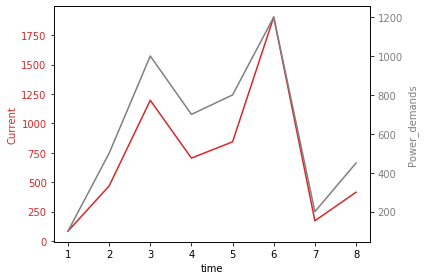

In [22]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Current', color=color)
ax1.plot(times,currents, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:grey'
ax2.set_ylabel('Power_demands', color=color)  # we already handled the x-label with ax1
ax2.plot(times, Power_demands, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Max Power vs Area needed Calculations:

#### Simplifying for now 

In [23]:
#E0_C = 0.401 #V vs SHE
#E0_A = -.763 #V vs SHE
#V_cell = E0_C - E0_A
# C_O2 = .21/22.4/1000 #mol O2 per cm^3



P = 1000 #kW
def area_needed(power):
    
    F = 96485.33212 #C/mol
    C_O2_paper = .008452 #mol/dm^3
    C_O2 = C_O2_paper/1000 #mol/cm^3

    V_cell = Nernst(298, [0.2095,6,0.2,6])

    #The relationship between k_f (cm/s) and Voltage (V) from kinetics proj.
    k_f = 6e-5 * np.exp(4.7921*V_cell) #cm/s

    i_k_amps = F*k_f*C_O2 # [C/mol * cm/s * mol/cm^3 = C/s-cm^2] = amps/cm^2
    i_k_mA = i_k_amps*1000
    i_k = i_k_mA
    
    A_required = power*(F*k_f*C_O2*V_cell)**(-1) #cm^2
    A_required_m = A_required/10000 #m^2
    
    return A_required_m


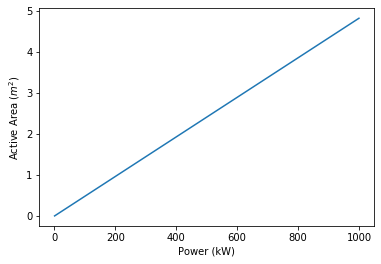

In [24]:
powers = np.linspace(1,1000)
areas = np.ones_like(powers)
for i in range(len(powers)):
    areas[i] = area_needed(powers[i])
    

plt.plot(powers,areas)
#plt.xlabel('Power')
plt.ylabel('Active Area ($m^2$)')
plt.xlabel('Power (kW)')
plt.show()

# Costs
From Techno-Economic Modeling and Analysis of RFB Paper

#### I. Energy

In [25]:
def cost_energy(cost_electrolyte, cost_tank):
    return cost_electrolyte + cost_tank

In [26]:
def cost_electrolyte():
    
    total = cost_active_material() 
    return total

SyntaxError: unexpected EOF while parsing (<ipython-input-26-c4d3465133f3>, line 1)